**CHE1148_4_Data_Process_Analytics_Data&Model Drift**

Your team has built a number of models over the years and now there is concern about their quality and possible drift. You will build a monitoring tool that captures model quality and drift. Use all data prior to Dec-2013 (inclusively) to train a model and calculate the baseline distributions you need for the first point of the dashboard based on this timeframe.
Then, you put this model in production and you calculate the scores for all clients after Jan-2014 (inclusively). You are asked to capture the drift of the model scores and the top 5 features of the model once it goes in production on Jan-2014.

Objective:
Create a dashboard that includes the Jensen-Shannon divergence metric with the training data as baseline distributions and monthly values after Jan-2014 for the following variables:
1. the monthly scores
2. the monthly top 5 features of the model

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import jensenshannon

import warnings
warnings.filterwarnings("ignore")

In [2]:

mth_rolling_features = pd.read_csv('mth_rolling_features.csv')
mth_day_counts = pd.read_csv('mth_day_counts.csv')
days_since_last_txn = pd.read_csv('days_since_last_txn.csv')
retail_data_response = pd.read_csv('Retail_Data_Response.csv')

# Rename 'customer_id' column to 'CLNT_NO' in 'mth_day_counts'
mth_day_counts.rename(columns={'customer_id': 'CLNT_NO'}, inplace=True)

# Merge the DataFrames using pd.merge, joining on 'CLNT_NO' and 'ME_DT'
mth_features = pd.merge(mth_rolling_features, mth_day_counts, on=['CLNT_NO', 'ME_DT'], how='left')
mth_features = pd.merge(mth_features, days_since_last_txn, on=['CLNT_NO', 'ME_DT'], how='left')
mth_features = pd.merge(mth_features, retail_data_response, left_on='CLNT_NO', right_on='customer_id', how='left')

# Drop the 'customer_id' column from 'mth_features'
mth_features.drop(columns=['customer_id'], inplace=True)

mth_features.to_csv('Monthly_Features')
# Drop rows with any missing values
mth_features.dropna(inplace=True)



In [3]:
mth_features = mth_features.sort_values(by=['ME_DT'])
mth_features = mth_features.reset_index(drop=True)
train = mth_features.loc[mth_features.ME_DT<'2014-01-31']
test = mth_features.loc[mth_features.ME_DT>='2014-01-31']

In [4]:
x_train = train.drop(['response'], axis = 1)
y_train = train['response']
X_train = x_train.drop(['CLNT_NO','ME_DT'],axis=1)
colnames = X_train.columns
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)

In [5]:

X_test = test.drop(['CLNT_NO','response'], axis = 1)
y_test = test['response']

**Model fitting**

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [200, 300],  # Number of trees in the forest
    'max_depth': [10, 20],  # Maximum depth of the tree
    'min_samples_split': [10, 20],  # Minimum number of samples required to split an internal node
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=1148)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit the grid search to the data
# Replace X_train and y_train with your actual training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Use the best estimator for further predictions
best_rf = grid_search.best_estimator_
# predictions = best_rf.predict(X_test)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best score: 0.8736909071402064


In [8]:
best_rf.fit(X_train_std, y_train)
feature_importances = best_rf.feature_importances_

In [14]:
impor = pd.DataFrame(feature_importances, index=X_train.columns, columns=['Feature Importance'])
impor = impor.sort_values(by=['Feature Importance'], ascending=False)
top_5_features = impor.index[0:5]
top_5_features

Index(['amt_mean_12M', 'amt_sum_12M', 'amt_max_12M', 'amt_sum_6M',
       'amt_max_6M'],
      dtype='object')

**Calculate Baseline Distribution**

In [58]:
baseline_scores = best_rf.predict_proba(X_train_std)[:, 1]
score_bins = np.quantile(baseline_scores, np.arange(0, 1.1, 0.1))
score_bins[0] = 0  # Adjust the first bin edge
baseline_hist = np.histogram(baseline_scores, bins=score_bins)


In [59]:
unique_months = X_test['ME_DT'].unique()
JS_scores = []

In [60]:
js_divergences_features = pd.DataFrame(index=top_5_features, columns=np.arange(len(unique_months)))

# Adjust bin edges for feature histograms
feature_bin_edges = np.r_[-np.inf, score_bins, np.inf]
# DataFrame for Jensen-Shannon divergence for top 5 features
JS_features = pd.DataFrame(index=top_5_features, columns=range(len(unique_months)))


In [61]:
# Extend bin edges to include all possible values
extended_bins = np.r_[-np.inf, score_bins, np.inf]

for i, month in enumerate(unique_months):
    month_data = X_test[X_test['ME_DT'] == month]
    month_data_std = scaler.transform(month_data.drop(['ME_DT'], axis=1))
    month_scores = best_rf.predict_proba(month_data_std)[:, 1]
    month_hist = np.histogram(month_scores, bins=score_bins)
    JS_scores.append(jensenshannon(baseline_hist[0], month_hist[0], 2.0))

    for feature in top_5_features:
        baseline_feature_dist = np.histogram(X_train[feature]/X_train[feature].max(), bins=extended_bins)[0]
        month_feature_dist = np.histogram(month_data[feature]/month_data[feature].max(), bins=extended_bins)[0]
        JS_features.at[feature, i] = jensenshannon(baseline_feature_dist, month_feature_dist, 2.0)



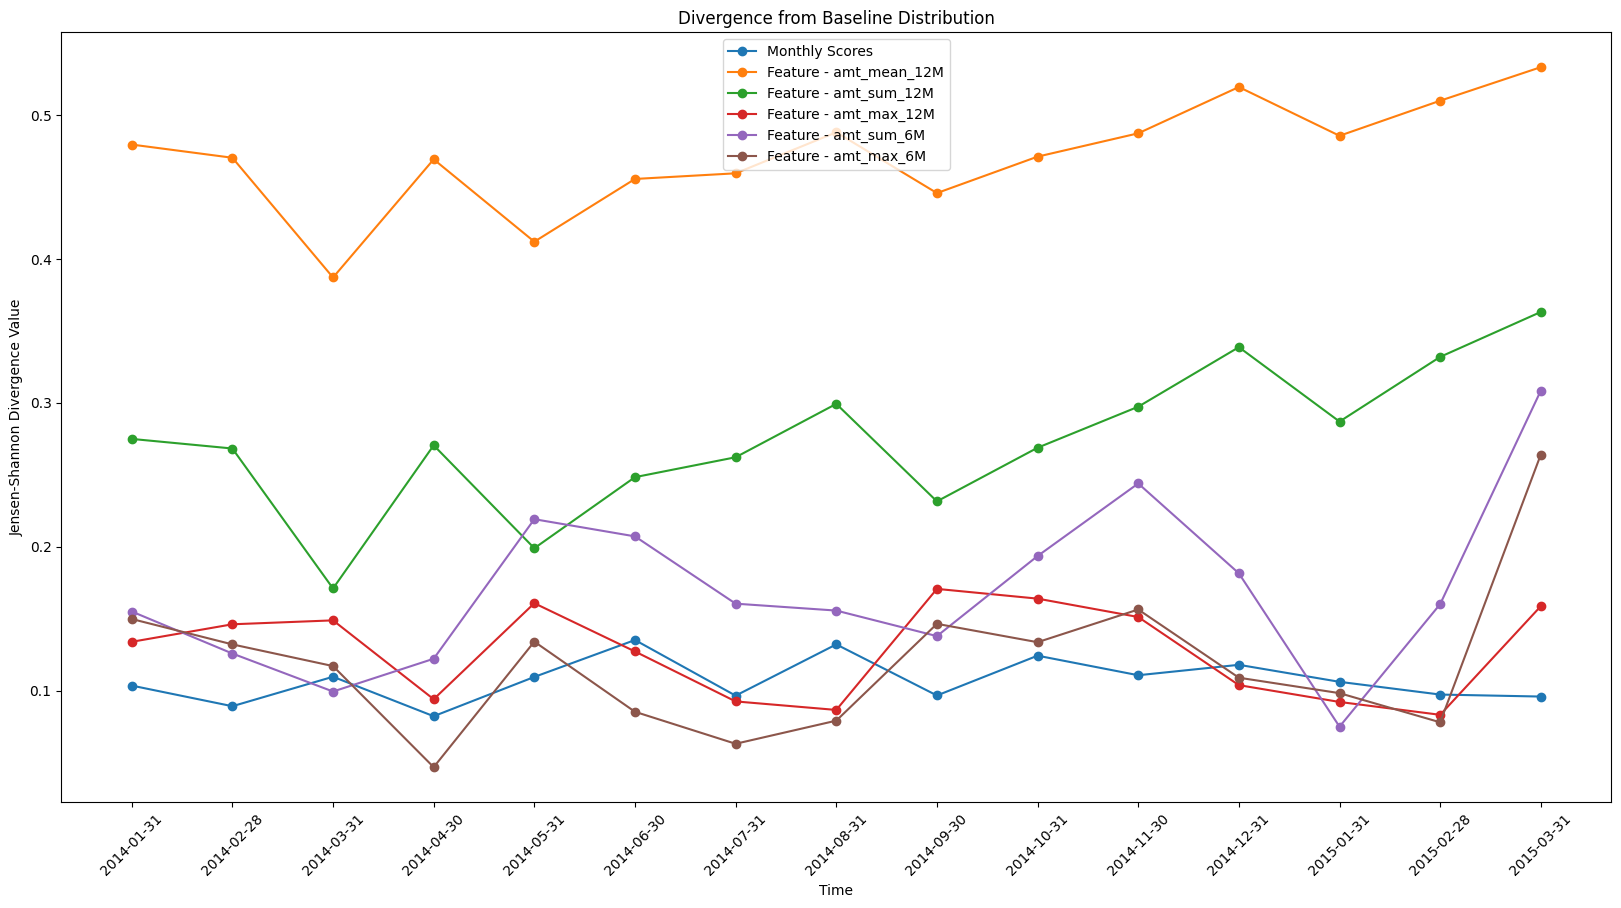

In [62]:
# Plotting
plt.figure(figsize=(20, 10))
plt.plot(unique_months, JS_scores, '-o', label='Monthly Scores')
for feature in top_5_features:
    plt.plot(unique_months, JS_features.loc[feature], '-o', label=f'Feature - {feature}')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Jensen-Shannon Divergence Value')
plt.title('Divergence from Baseline Distribution')
plt.xticks(rotation=45)
plt.show()

**Discussion**

The graph depicting the Jensen-Shannon divergence over time illustrates distinct trends in the divergence values for model scores and individual features since January 2014. The model score trend, while showing some fluctuations, reveals a general increase in divergence from the baseline, suggesting a gradual drift in model predictions over time. This could indicate that the model is becoming less representative of the current data, a classic symptom of model drift that warrants closer inspection and potential retraining.

Regarding the divergence of individual features, the trends vary. For instance, the features `amt_mean_12M` and `amt_sum_12M` demonstrate moderate and relatively stable divergence, indicating some changes in their distributions but no abrupt shifts. The feature `amt_max_12M` shows the least amount of volatility, suggesting a stable distribution relative to the baseline over the observed period. In contrast, `amt_sum_6M` displays a more pronounced upward trend in divergence, signaling more significant changes in its distribution, which could be indicative of underlying shifts in consumer behavior or other external factors. Most notably, `amt_max_6M` experiences a stark increase in divergence towards the later months in the graph, highlighting a substantial change that may be attributed to recent events or trends affecting this feature.

These divergence patterns offer actionable insights, indicating that certain features may be influencing the model's predictive power differently as time progresses. The variability seen in `amt_sum_6M` and the spike for `amt_max_6M` are particularly intriguing and could reflect real-world changes in the factors they represent. Continuous monitoring is vital to ensure the model's robustness and reliability. The insights gleaned from this analysis should lead to a deeper dive into the causes of these changes, whether they be natural evolutions in the dataset or shifts in external conditions. Ultimately, staying vigilant about these changes is crucial for maintaining the accuracy and reliability of predictive models in dynamic environments.